In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After concatenation of BoAW_MFCC and BoAW_eGeMAPS

Bi-LSTM APPLIED

In [8]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ## 1. Setup and Imports




In [9]:
pip install torch

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# ## 2. Define Paths and Parameters

In [12]:
# CONFIG
FEATURE_DIM = 200  # 100 MFCC + 100 eGeMAPS
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
NUM_CLASSES = 2   # or 2 if binary classification
DATA_DIR = r"/content/drive/MyDrive/CGS616_project_data/Audio_model/BoAW_combined_no_timestamp" #access concatenated datasets
LABEL_FILE = r"/content/drive/MyDrive/CGS616_project_data/Audio_model/B_classified_labels.csv"

# ## 3. Find the Max_Timestamp


In [13]:
MAX_TIMESTEPS = 10000

# ##Encode *Labels*

In [14]:
# Load labels
label_df = pd.read_csv(LABEL_FILE)
label_map = {str(row['Participant']): row['Sleep_Disorder'] for _, row in label_df.iterrows()}

In [15]:
from collections import Counter

# Suppose your labels are loaded properly
label_counts = Counter(label_df['Sleep_Disorder'])  # Only use the labels column
print(label_counts)

# Now compute inverse class weights
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in range(len(label_counts))]
weights = torch.tensor(class_weights).to(device)

# Correctly define the loss
criterion = nn.CrossEntropyLoss(weight=weights)

Counter({0: 176, 1: 99})


# ## 4. Define SleepDataset

In [16]:
# Dataset class
class SleepDataset(Dataset):
    def __init__(self, feature_dir, label_map, max_len):
        self.paths = sorted([os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith(".csv")])
        self.label_map = label_map
        self.max_len = max_len

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        pid = os.path.basename(path).split('_')[0]
        X = pd.read_csv(path).values
        X = StandardScaler().fit_transform(X)
        X = X[:self.max_len, :]
        if X.shape[0] < self.max_len:
            X = np.pad(X, ((0, self.max_len - X.shape[0]), (0, 0)))
        y = self.label_map.get(pid, -1)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)



# ## 6. Define BiLSTM Model

In [17]:
import torch.nn as nn
import torch

# class BiLSTMModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.lstm1 = nn.LSTM(input_dim, 64, batch_first=True, bidirectional=True, dropout=0.2)
#         self.lstm2 = nn.LSTM(128, 32, batch_first=True, bidirectional=True, dropout=0.2)

#         self.norm = nn.LayerNorm(64)  # Normalizing after second BiLSTM (128 / 2)
#         self.pool = nn.AdaptiveAvgPool1d(1)
#         self.dropout = nn.Dropout(0.4)

#         self.fc1 = nn.Linear(64, 32)
#         self.fc2 = nn.Linear(32, output_dim)

#     def forward(self, x):
#         x, _ = self.lstm1(x)
#         x = self.dropout(x)

#         x, _ = self.lstm2(x)
#         x = self.dropout(x)

#         x = x.transpose(1, 2)            # shape: (B, F, T)
#         x = self.pool(x).squeeze(-1)     # shape: (B, F)
#         x = self.norm(x)
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         return self.fc2(x)

#         import torch.nn as nn
import torch

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 128, batch_first=True, bidirectional=True, dropout=0.3)

        self.norm = nn.LayerNorm(256)  # Because bidirectional: 128 * 2
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)              # [batch, seq, 256]
        x = self.dropout(x)
        x = x.transpose(1, 2)            # [batch, 256, seq]
        x = self.pool(x).squeeze(-1)     # [batch, 256]
        x = self.norm(x)
        x = torch.relu(self.fc1(x))      # [batch, 64]
        x = self.dropout(x)
        return self.fc2(x)               # [batch, output_dim]


# ## 7. Initialize Model, Loss, Optimizer

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# ##8 Data Loading, Training and Evaluation

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from copy import deepcopy

def train_and_evaluate():
    model = BiLSTMModel(FEATURE_DIM, NUM_CLASSES).to(device)


    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    best_model_state = None
    best_test_acc = 0
    early_stopper = EarlyStopping(patience=15, min_delta=0.001)

    dataset = SleepDataset(DATA_DIR, label_map, 8000)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 🔒 Clip grads
            optimizer.step()
            total_loss += loss.item()
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(total_loss)
        train_accuracies.append(train_acc)

        # --- Eval
        model.eval()
        test_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                test_loss += loss.item()
                all_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        test_acc = accuracy_score(all_labels, all_preds)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"Train Loss: {total_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

        # --- Early stopping check
        early_stopper(1 - test_acc)
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = deepcopy(model.state_dict())

        if early_stopper.early_stop:
            print("⏹️ Early stopping triggered.")
            break

        # Load the best model (important before final evaluation)
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), "/content/drive/MyDrive/CGS616_project_data/Audio_model/best_bilstm_model.pt")
    model.eval()

    # --- Evaluate again on test set for final plots ---
    test_preds, test_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            test_preds.extend(preds.argmax(dim=1).cpu().numpy())
            test_labels.extend(yb.cpu().numpy())

    # --- Final Test Accuracy ---
    final_test_acc = accuracy_score(test_labels, test_preds)
    print(f"✅ Final Test Accuracy after reloading best model: {final_test_acc:.4f}")

    # --- Generate Plots ---
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(18, 5))

    # 1. Loss Curves
    plt.subplot(1, 4, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color='red')
    plt.plot(epochs, test_losses, label="Test Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # 2. Accuracy Curves
    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(epochs, test_accuracies, label="Test Accuracy", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    # 3. Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    num_classes = cm.shape[0]

    plt.subplot(1, 4, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(num_classes),
                yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    # 4. F1-score per class
    report = classification_report(test_labels, test_preds, digits=4, output_dict=True)
    classes = list(report.keys())[:-3]  # Remove avg metrics like 'macro avg'

    f1_scores = [report[cls]['f1-score'] for cls in classes]

    plt.subplot(1, 4, 4)
    plt.bar(classes, f1_scores, color='purple')
    plt.xlabel("Classes")
    plt.ylabel("F1-Score")
    plt.title("F1-Score Per Class")
    plt.xticks(rotation=45)

    # --- Show all 4 plots together ---
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/20 | Train Loss: 5.0964, Acc: 0.4558 | Test Loss: 1.3622, Acc: 0.6111
Epoch 2/20 | Train Loss: 4.9017, Acc: 0.5628 | Test Loss: 1.3767, Acc: 0.5926
Epoch 3/20 | Train Loss: 4.6968, Acc: 0.5721 | Test Loss: 1.3765, Acc: 0.4815
Epoch 4/20 | Train Loss: 4.6889, Acc: 0.5628 | Test Loss: 1.3689, Acc: 0.5370
Epoch 5/20 | Train Loss: 4.5997, Acc: 0.5953 | Test Loss: 1.3609, Acc: 0.6111
Epoch 6/20 | Train Loss: 4.6560, Acc: 0.5907 | Test Loss: 1.3498, Acc: 0.6481
Epoch 7/20 | Train Loss: 4.5426, Acc: 0.6465 | Test Loss: 1.3518, Acc: 0.6111
Epoch 8/20 | Train Loss: 4.4744, Acc: 0.6698 | Test Loss: 1.3393, Acc: 0.6296
Epoch 9/20 | Train Loss: 4.4986, Acc: 0.6558 | Test Loss: 1.3345, Acc: 0.6296
Epoch 10/20 | Train Loss: 4.4039, Acc: 0.6419 | Test Loss: 1.3430, Acc: 0.6111
Epoch 11/20 | Train Loss: 4.3525, Acc: 0.6837 | Test Loss: 1.3415, Acc: 0.5741
Epoch 12/20 | Train Loss: 4.3598, Acc: 0.6558 | Test Loss: 1.3349, Acc: 0.5741
Epoch 13/20 | Train Loss: 4.2366, Acc: 0.7070 | Test Loss: 1.

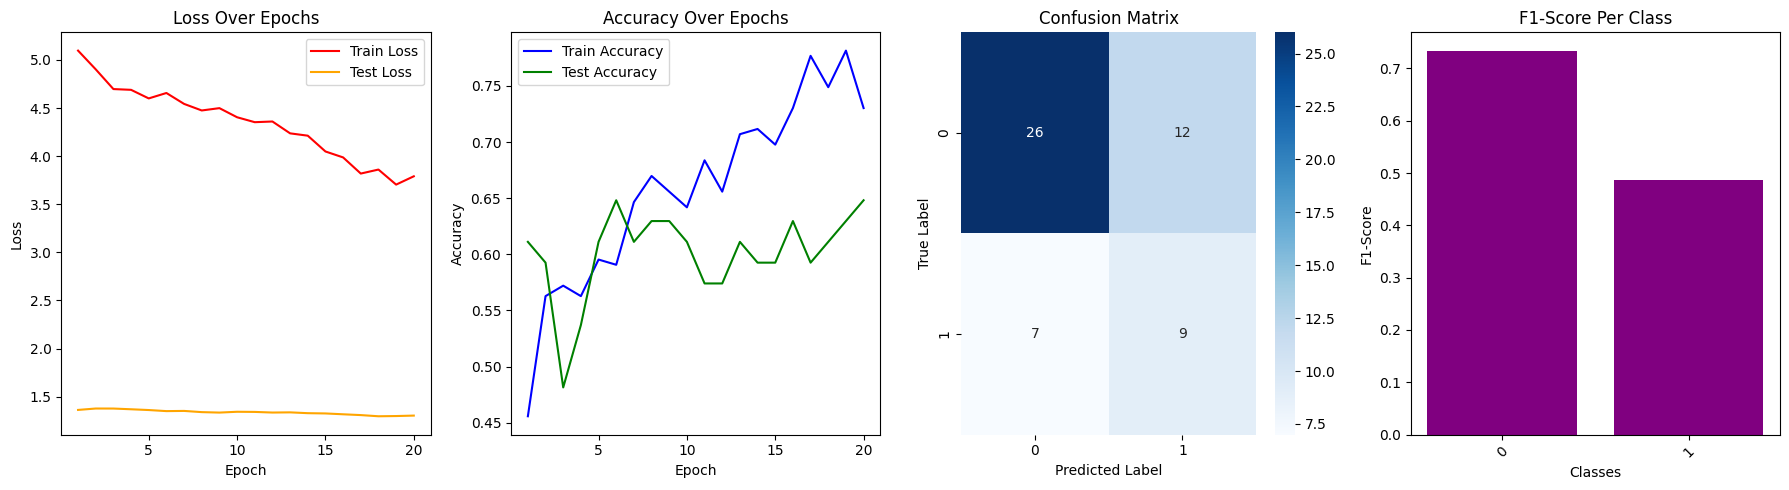

In [22]:
# Run the training
if __name__ == "__main__":
    train_and_evaluate()